The following code is mostly reproduced: <br>
Reference: Gaussian Mixture Models - Predicting Customer Churn <br>
https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [5]:
x = np.linspace(start= -10, stop = 10, num = 1000)

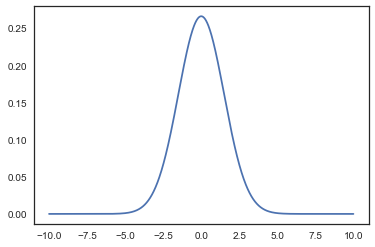

In [6]:
x.shape # (1000,)
# x # array([-10.        ,  -9.97997998,  -9.95995996,  -9.93993994, -9.91991992,
# loc is mean and scale is standard deviation
y = stats.norm.pdf(x, loc=0, scale=1.5)
# y # array([5.94060012e-11, 6.49283304e-11, 7.09513704e-11, 7.75193242e-11,
plt.plot(x,y)

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("bimodal_example.csv")
df.shape # (100,1)
df.head()

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


In [9]:
data = df.x

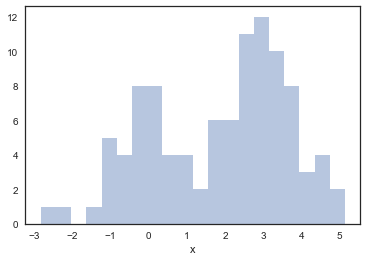

In [10]:
sns.distplot(data, bins=20, kde = False)

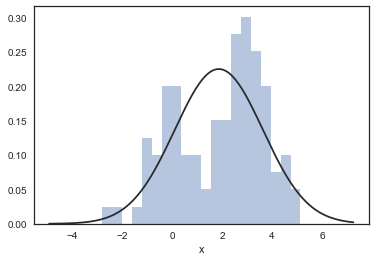

In [11]:
sns.distplot(data, fit = stats.norm, bins = 20, kde = False,)

Define The Model
Two Normal distributions $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$.
There are 5 paramaters: 4 of the them are Normal distributions and 1 more for the probability of choosing one of them.
Let $w$ be the probability that the data comes from the first Normal, the parameter in this model is $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$.
The probability density function (PDF) is:
$$f(x | \theta) = w \  f_1(x \ | \  \mu_1, \sigma_1^2) + (1 - w) \  f_2 (x  \ | \  \mu_2, \sigma_2^2) $$

EM is tyring to maximize the following functions: <br>
* X is directly observed variable
* _theta parameters of model
* Z is not directly observed / latent variable
- Z is a joint (related) distribution on x.

EM steps, stated another way <br>
1. Initialize the parameters of the models, either randomly or doing a 'smart seeding'
2. E Step: Find the posterior probabilities of the latent variable given current parameter values
3. M Step: Reestimate the parameter values given the current posterior probabilities.
4. Repeat 2-3 monitoring the likelihood function likelihood. Hope for convergence    

In [49]:
import math
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    #probability density function
    def pdf(self, x):
        mu = self.mu
        sig = self.sigma
        return 1./(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    # printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(best_single.mu, best_single.sigma)

In [50]:
# gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: mu = {:.2}, sigma = {:.2}'.format(best_single.mu,best_single.sigma))

Best single Gaussian: mu = 1.9, sigma = 1.8


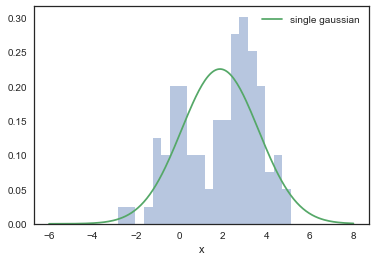

In [14]:
# fit a single gaussian curve to the data
x = np.linspace(-6,8,200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label = 'single gaussian')
plt.legend();
#plt.plot(g_single)

In [15]:
from math import sqrt, log, exp, pi
from random import uniform

In [51]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"
    def __init__(self, data, mu_min = min(data),
                mu_max=max(data), sigma_min=.1,sigma_max=1,
                mix = .5):
        self.data = data
        # init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max),
                           uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max),
                           uniform(sigma_min, sigma_max))
        # as well as how much to mix them
        self.mix = mix
        
    def Estep(self):
        "Perform an E(estimation)-step, freshing up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p=1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 = wp1 / den
            wp2 = wp2 / den
            # add into loglike
            self.loglike = self.loglike + log(wp1 + wp2)
            
            #yield weight tuple
            yield (wp1, wp2)
    
    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w,d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w,d) in zip(right, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d  - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) **2)
                                  for (w, d) in zip(right, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(N):
            weights = self.Estep()
            self.Mstep(weights)
            print(self.__str__())
        
    def pdf(self, x):
        return (self.mix) * self.one.pdf(x) + (1-self.mix) * self.two.pdf(x)
    
    def __repr__(self):
        return "GaussianMixture({0}, {1}, mix = {2.03})".format(self.one, self.two, self.mix)
        
    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)        
                

In [64]:
# Check out the fitting process
n_iterations = 500
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        # train:
        mix.iterate(verbose = True)
        print ("mix.loglike: ", mix.loglike)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
    # Catch division errors from bad start s, and just throw them out..
    except (ZeroDivisionError, ValueError, RuntimeWarning):
        pass
        

Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.231)
mix.loglike:  -1.3322676295501878e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.2)
mix.loglike:  -6.661338147750939e-16
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.191)
mix.loglike:  -1.9984014443252818e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.192)
mix.loglike:  -1.5543122344752192e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.201)
mix.loglike:  -9.992007221626409e-16
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.214)
mix.loglike:  -1.3322676295501878e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.231)
mix.loglike:  -1.2212453270876722e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.251)
mix.loglike:  -2.1094237467877974e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.271)
mix.loglike:  -1

In [67]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                print("mix.loglike: ", mix.loglike)
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...

Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0427)
mix.loglike:  -1.5543122344752192e-15
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0296)
mix.loglike:  -3.3306690738754696e-16
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.023)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0191)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0168)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0155)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0152)
mix.loglike:  -4.930380657631324e-32
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0157)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0173)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0186)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.0

/Users/gonsoomoon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/gonsoomoon/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars


Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.389)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.386)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.382)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.38)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.377)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.376)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=0.374)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=nan)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=nan)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=nan)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=nan)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=nan)
Mixture: Gaussian(1.86285, 1.77022), Gaussian(1.86285, 1.77022), mix=nan)
Mixture: Gaussian(1.86285

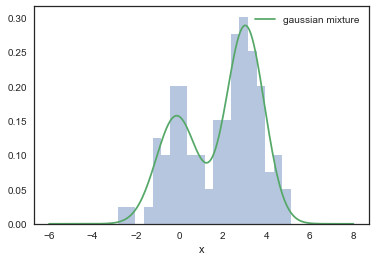

In [66]:
#mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();